In [1]:
import numpy as np
import scipy.stats as ss
import numpy.random as npr
import pandas as pd

import seaborn as sns
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [144]:
def generate_user(n_classes=3, n_components=2, n_interests=2, p_c=[0.2, 0.5, 0.3], p_m=[[0.1, 0.9], [0.5, 0.5], [0.7, 0.3]], mu=[35.0, 20.0, 15.0], std=10.0, lbd=[2.0, 3.0, 1.0], p_i = [[0.1, 0.8], [0.5, 0.5], [0.9, 0.2]]):
    assert len(p_c) == n_classes
    assert np.array(p_m).shape == (n_classes, n_components)
    assert np.array(p_i).shape == (n_classes, n_interests)
    
    result = {}
    
    klass = np.arange(n_classes)[npr.multinomial(1, p_c).astype(bool)][0]
    # print "Sampled class: %s" % klass
    result["klass"] = klass    
    
    for j in xrange(n_interests):
        result["int_%d" % j] = int(npr.random() < p_i[klass][j])
    
    p_mix = p_m[klass]
    # print "P_mixture: %s" % p_mix    
    
    n_presents = npr.zipf(2.4, 1)
    for j in xrange(n_presents):   
        component = np.arange(n_components)[npr.multinomial(1, p_mix)][0]
        # print "Sampled_component: %s" % component    

        if component == 0:
            # Exponential
            p = np.ceil(npr.exponential(1.0/lbd[klass]))
        elif component == 1:
            # Normal
            p = int(npr.normal(mu[klass], std, 1)[0] + 1)
        # print "Sampled price %s" % p        
        
        if p > 0 and p <= 100:
            result[p] = result.get(p, 0) + 1
    
    if sum([result.get(n, 0) for n in xrange(1, 101)]) > 0:
        return result
    else:
        return generate_user(n_classes, n_components, n_interests, p_c, p_m, mu, std, lbd, p_i)    

In [3]:
df = pd.DataFrame([generate_user() for i in xrange(1000000)], columns=["klass", "int_0", "int_1"] + range(1, 101))
df.fillna(0, inplace=True)

df.head()

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


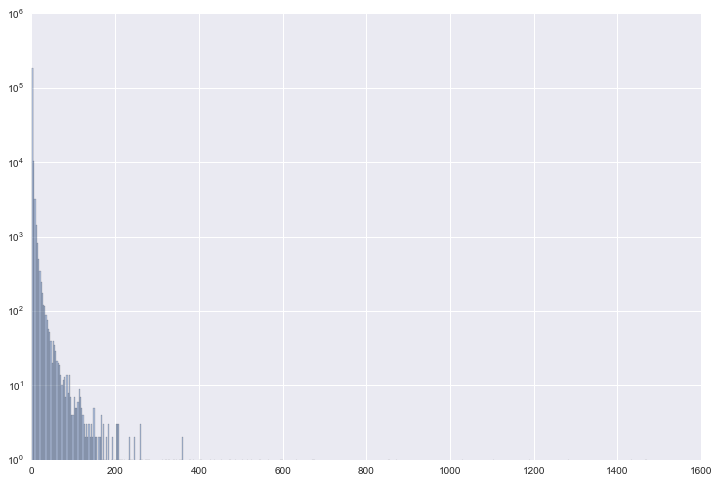

In [4]:
pl.figure(figsize=(12, 8))
sns.distplot(df[df["klass"] == 0][range(1, 101)].sum(axis=1), bins=500, rug=False, kde=False)
pl.gca().set_yscale('log')
pl.show()

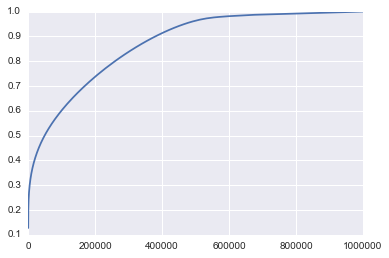

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
662394,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94027,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366578,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
spent = pd.Series(df[range(1, 101)].values.dot(range(1, 101)), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
dfs = df.ix[spent.sort_values(ascending=False).index[:300000]].sample(100000)

dfs.head()

In [6]:
dfs.head().sum(axis=1)

662394    2
729610    2
94027     2
366578    5
509988    1
dtype: float64

In [7]:
def visualize_dist(dfx, N=None, M=None, color='r'):
    if N is None:
        N = np.ceil(np.sqrt(dfx.shape))
        M = np.ceil(np.sqrt(dfx.shape))

    fig = pl.figure(figsize=(M*3, N*3))

    for i, (uid, row) in enumerate(dfx.sample(N*M).iterrows()):
        ax = pl.subplot(N, M, i + 1)
#         print row.index, row.values
        ax.bar(row.index + 0.5, row.values, color=color, alpha=0.7)
        pl.title(uid)
        pl.xticks(range(0, 101, 20))
        pl.xlim(0, 101)
        pl.ylim(0, 100)
    
    fig.tight_layout()
    pl.show()

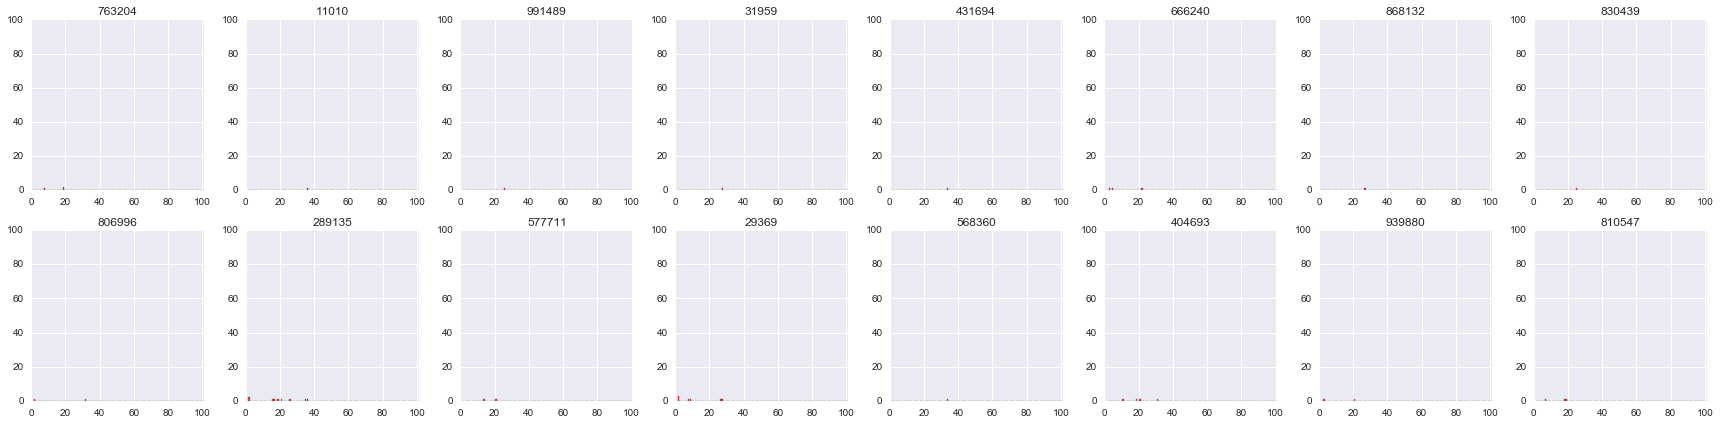

In [8]:
visualize_dist(dfs[dfs["klass"] == 2][range(1, 101)], 2, 8)

## Bayesian

### EMCEE

In [117]:
import emcee
print emcee.__version__

n_classes = 3
n_interests = 2
n_users = 2

2.1.0


### Prior

In [118]:
def flatten_hyper(K, I):
    return np.hstack([K.ravel(), I.ravel()])

def shapen_hyper(theta):
    K_flat, I_flat = theta[:n_users*n_classes], theta[n_users*n_classes:]    
    K = np.reshape(K_flat, (n_users, n_classes))
    I = np.reshape(I_flat, (n_classes, n_interests))
    
    return K, I

In [119]:
alpha = np.ones(n_classes, dtype=float) / n_classes

def class_log_prior(K):    
    """Uniform priors on all probabilities"""
    assert np.shape(K) == (n_users, n_classes)
    
#     if not all([k == 1.0 or k == 0.0 for ind, k in np.ndenumerate(K)]):
#         return -np.inf

    if not all([0.0 <= k <= 1.0 for ind, k in np.ndenumerate(K)]):
        return -np.inf
    if not all([s == 1.0 for s in np.sum(K, axis=1)]):
        return -np.inf
    
    return sum(ss.dirichlet.logpdf(k, alpha) for k in K)

# print class_log_prior([[0.98,0.01,0.01], [0.01, 0.98,0.01]])
# assert class_log_prior([[0, 0, 1, 0], [0.5, 0, 0.5, 0]]) == -np.inf
# assert class_log_prior([[0, 0, 1, 0], [1, 0, 1, 0]]) == -np.inf

def interests_log_prior(I):
    assert np.shape(I) == (n_classes, n_interests)
    
    if not all([0.0 <= i <= 1.0 for ind, i in np.ndenumerate(I)]):
        return -np.inf
    return 0

# assert interests_log_prior([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]]) == 0
# assert interests_log_prior([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [1.7, 0.9]]) == -np.inf

def log_prior(theta):
    K, I = shapen_hyper(theta)
    
    return class_log_prior(K) + interests_log_prior(I)
    
# assert log_prior(np.hstack([np.ravel([[0, 1, 0, 0], [1, 0, 0, 0]]), np.ravel([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]])])) == 0
# assert log_prior(np.hstack([np.ravel([[0, 1, 0, 0], [1, 0, 0, 1]]), np.ravel([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]])])) == -np.inf
# assert log_prior(np.hstack([np.ravel([[0, 1, 0, 0], [1, 0, 0, 0]]), np.ravel([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [1.7, 0.9]])])) == -np.inf

### Likelihood

In [120]:
def like_I_nj(I_nj, n, j, K, I):
    k_max = np.max(K, axis=1)
    p = 0
    for k in xrange(n_classes):
        p += int(K[n][k] == k_max[n]) * np.power(I[k][j], I_nj) * np.power(1 - I[k][j], 1 - I_nj)
    return p

# assert like_I_nj(1, 0, 1, [[0, 1, 0, 0], [1, 0, 0, 0]], [[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]]) == 0.6
# assert like_I_nj(0, 1, 0, [[0, 1, 0, 0], [1, 0, 0, 0]], [[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]]) == 0.5

def log_like_I(i, K, I):
    assert np.shape(i) == (n_users, n_interests)
    ll = 0
    for (n, j), I_nj in np.ndenumerate(i):        
        ll += np.log(like_I_nj(I_nj, n, j, K, I))
    return ll

def log_like(theta, i):
    K, I = shapen_hyper(theta)    
    
    return log_like_I(i, K, I)

# assert log_like(np.hstack([np.ravel([[0, 1, 0, 0], [1, 0, 0, 0]]), np.ravel([[0.5, 0.4], [0.1, 0.6], [0.3, 0.1], [0.7, 0.9]])]), [[0, 1], [1, 1]]) == np.log(0.9 * 0.6 * 0.5 * 0.4)

def log_posterior(theta, i):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_like(theta, i)

In [121]:
n_users = 20

df = pd.DataFrame([generate_user() for i in xrange(n_users)], columns=["klass", "int_0", "int_1"] + range(1, 101))
df.fillna(0, inplace=True)

df.head()

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
def write_subchain(subchain, file_name, batch_start_iter):
    with open("/Users/anokhin/Desktop/chain.dat", "a") as f:
        for j in xrange(subchain.shape[0]):
            for k in range(subchain.shape[1]):
                print >> f, "%d\t%d\t%s" % (j + batch_start_iter, k, ",".join(["%.3f" % v for v in subchain[j, k]]))

n_dim = n_users * n_classes + n_classes * n_interests
n_walkers = n_dim * 3
print "n_dim=%d, n_walkers=%d" % (n_dim, n_walkers)

def init_theta():
#     K = npr.multinomial(1, np.ones(n_classes, dtype=float) / n_classes, size=n_users)
    K = npr.random(size=(n_users, n_classes))
    K = K / np.sum(K, axis=1)[:, np.newaxis]
    I = npr.random(size=(n_classes, n_interests))
    return flatten_hyper(K, I)

theta = [init_theta() for k in range(n_walkers)]
print np.shape(theta)

# Set up the sampler.
i = df[["int_0", "int_1"]]

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=[i])

# Run a burn-in chain and save the final location.
batch_size = 100
burn_batches = 5
sample_batches = 50

subchain = np.zeros((batch_size, n_walkers, n_dim))
                
file_name = "/Users/anokhin/Desktop/chain.dat"
with open(file_name, "w") as f:
    pass
    
for i, result in enumerate(sampler.sample(theta, iterations=batch_size*sample_batches, storechain=False)):
    if i >= burn_batches * batch_size and i % batch_size == 0:
        write_subchain(subchain, file_name, i - batch_size)
    
    subchain[i % batch_size] = result[0]
else:
    write_subchain(subchain, file_name, i - batch_size + 1)

n_dim=66, n_walkers=198
(198, 66)


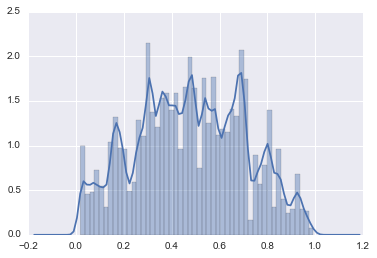

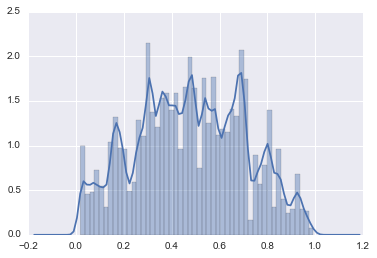

In [124]:
i_00 = []
i_01 = []

with open("/Users/anokhin/Desktop/chain.dat") as resf:
    for line in resf:
        i, w, d = line.strip().split("\t")
        
        it = int(i)
        walker = int(w)
        K, I = shapen_hyper([float(v) for v in d.split(",")])
        i_00.append(I[0, 1])
        i_01.append(I[0, 1])
            
sns.distplot(i_00)
pl.show()
            
sns.distplot(i_01)
pl.show()

### PyMC

In [145]:
import pymc as pm

n_classes = 3
n_users = 100
n_interests = 2

df = pd.DataFrame([generate_user() for i in xrange(n_users)], columns=["klass", "int_0", "int_1"] + range(1, 101))
df.fillna(0, inplace=True)

df.head()

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
def interest_selector(klass, interest_priors):
    return interest_priors[klass]

def model_definition(n_classes, n_interests, n_users):
    # Class prior
    klass_prior = pm.Dirichlet("klass_prior", theta=np.ones(n_classes, dtype=float))
    m["klass_prior"] = klass_prior
    
    # Priors for interests
    interests_priors = np.empty((n_interests, n_classes), dtype=object)
    for j in xrange(n_interests):
        for k in xrange(n_classes):        
            interests_priors[j, k] = pm.Uniform("interest_prior_%d_%d" % (j, k), 0, 1)

    # For each user generate class
    klasses = np.empty(n_users, dtype=object)
    # For each user generate 0-1 interests
    interests = np.empty((n_users, n_interests), dtype=object)
    interest_selectors = np.empty((n_users, n_interests), dtype=object)
    
    for i in xrange(n_users):        
        klasses[i] = pm.Categorical("klass_%d" % i, klass_prior)
        
        for j in xrange(n_interests):
            interest_selectors[i, j] = pm.Deterministic(
                eval=interest_selector, 
                name='is_%d_%d' % (i, j), 
                doc="Assigns interest probability using current user's class", 
                parents={'klass': klasses[i], 'interest_priors': interests_priors[j, :]}, 
                trace=True, verbose=0, dtype=float, plot=True, cache_depth=2
            )
            interests[i, j] = pm.Bernoulli("interest_%d_%d" % (i, j), interest_selectors[i, j], value=df.ix[i]["int_%d" % j], observed=True)
        
    # print np.bincount([k.value.tolist() for k in klasses])
        
    return locals()

mcmc = pm.MCMC(model_definition(n_classes, n_interests, n_users))
mcmc.sample(10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 341.4 sec

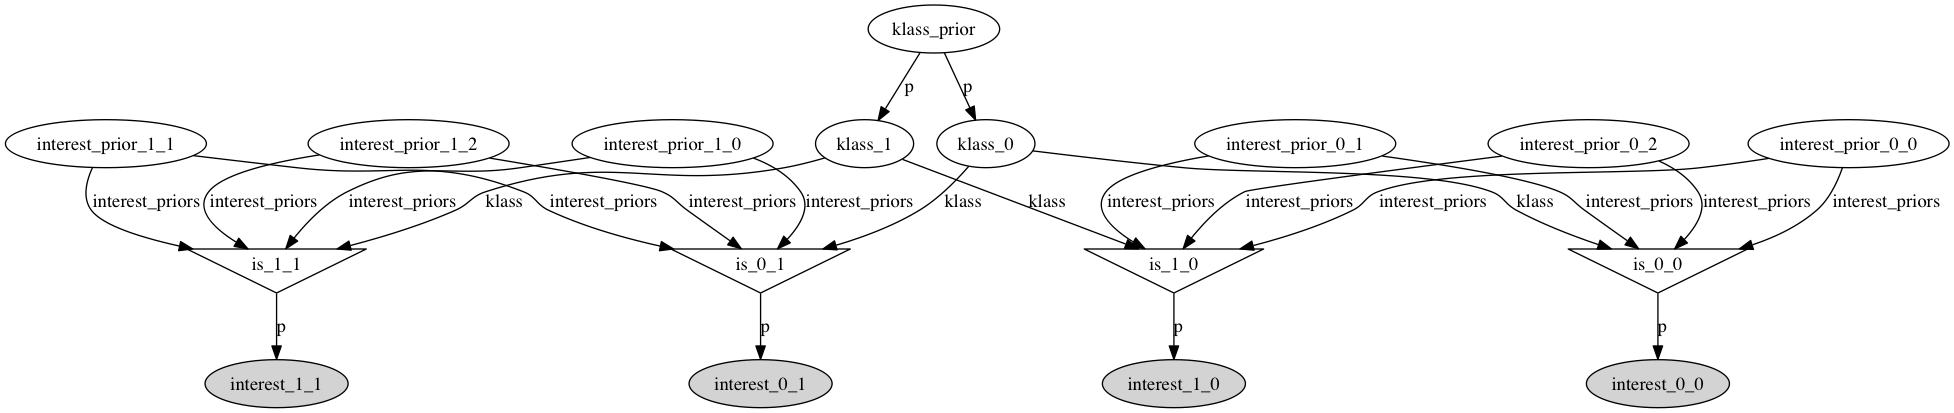

In [140]:
gr = pm.graph.graph(mcmc)
gr.write_png('/Users/anokhin/Desktop/model.png')
from IPython.display import Image
Image(filename='/Users/anokhin/Desktop/model.png') 

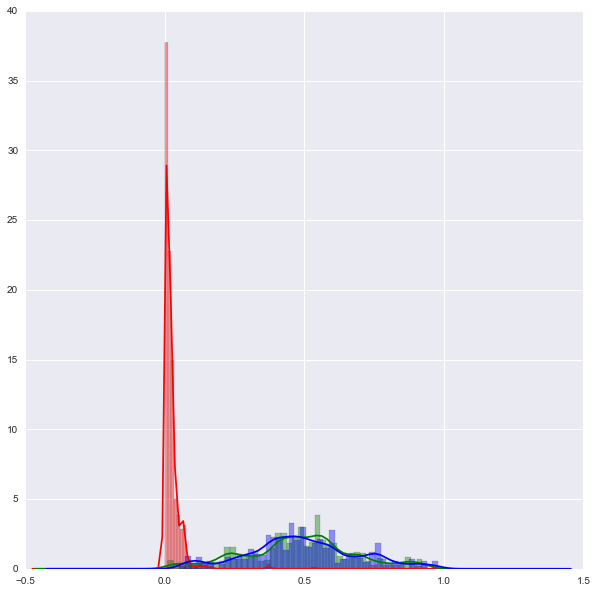

In [150]:
klass_prior_trace = mcmc.trace("klass_prior")[:]

# for pretty colors later in the book.
colors = ["r", "g", "b"]

pl.figure(figsize=(10, 10))
sns.distplot(klass_prior_trace[:, 0], label="trace of prior 0", color=colors[0])
sns.distplot(klass_prior_trace[:, 1], label="trace of prior 1", color=colors[1])
sns.distplot(1 - klass_prior_trace.sum(axis=1), label="trace of prior 2", color=colors[2])
pl.show()

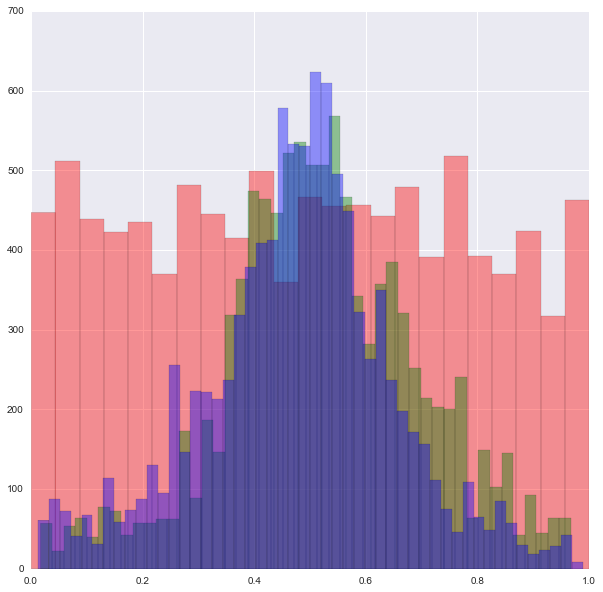

In [151]:
i_0_0_prior_trace = mcmc.trace("interest_prior_1_0")[:]
i_1_0_prior_trace = mcmc.trace("interest_prior_1_1")[:]
i_2_0_prior_trace = mcmc.trace("interest_prior_1_2")[:]

pl.figure(figsize=(10, 10))
sns.distplot(i_0_0_prior_trace, label="trace of inetrest 0 prior for class 0", color='r', kde=False)
sns.distplot(i_1_0_prior_trace, label="trace of inetrest 0 prior for class 1", color='g', kde=False)
sns.distplot(i_2_0_prior_trace, label="trace of inetrest 0 prior for class 2", color='b', kde=False)
pl.show()